In [79]:
import torch,copy,argparse,csv
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data

## Load data

In [80]:
velocity_coeff = np.genfromtxt('./data/POD_coeffs_3900_new_grid_221_42_Velocity_1.csv', delimiter=',')
pressure_coeff = np.genfromtxt('./data/POD_coeffs_3900_new_grid_221_42_Pressure_1.csv', delimiter=',')

In [81]:
coeff_all = torch.from_numpy(np.append(velocity_coeff,pressure_coeff,axis=0)).type(torch.FloatTensor)
scaler = MinMaxScaler()
scaler.fit(coeff_all.T)
coeff_all_scaled = torch.from_numpy(scaler.transform(coeff_all.T)).type(torch.FloatTensor)
data = copy.deepcopy(coeff_all_scaled[:-1,:])
label = copy.deepcopy(coeff_all_scaled[1:,:])

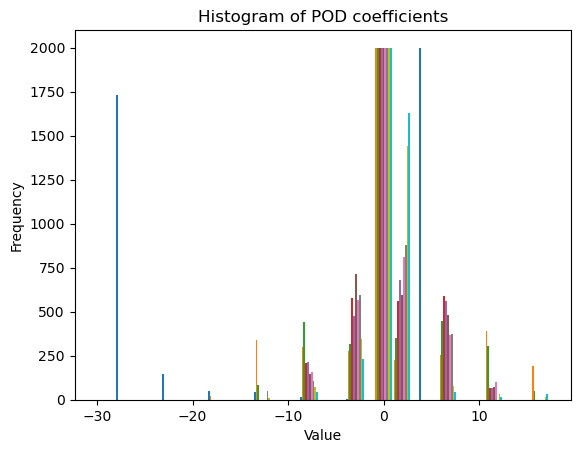

In [143]:
n, bins, patches = plt.hist(x=coeff_all)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of POD coefficients')
plt.show()

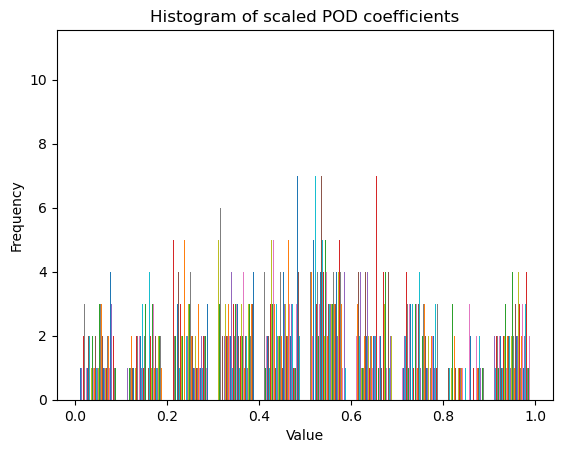

In [144]:
n, bins, patches = plt.hist(x=coeff_all_scaled)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of scaled POD coefficients')
plt.show()

In [82]:
x_train, x_test, y_train, y_test = train_test_split(data,label, test_size=0.3 , random_state=2)

In [106]:
def norm_inverse(data_scaled, scaler):
    data = (data_scaled - torch.tensor(scaler.min_).type(torch.FloatTensor))/torch.tensor(scaler.scale_).type(torch.FloatTensor)
    return data

## Compute residuals

In [107]:
basis_v = torch.from_numpy(np.genfromtxt('./data/Velocity_basis.csv', delimiter=',')).type(torch.FloatTensor)
basis_p = torch.from_numpy(np.genfromtxt('./data/Pressure_basis.csv', delimiter=',')).type(torch.FloatTensor)

In [108]:
def backward_p(coeff_p, basis_p):
    length, number = coeff_p.shape
    nx = 221
    ny = 42
    grid_p = torch.matmul(basis_p, coeff_p)
    return grid_p.reshape(nx,ny,number)

In [109]:
def backward_v(coeff_v, basis_v):
    length, number = coeff_v.shape
    nx = 221
    ny = 42
    grid_v = torch.matmul(basis_v, coeff_v)
    grid_v1 = grid_v[0:nx*ny].reshape(nx,ny,number)
    grid_v2 = grid_v[nx*ny:].reshape(nx,ny,number)
    return grid_v1, grid_v2

In [110]:
def backward(coeff, basis_v, basis_p):
    nPOD = 10
    coeff_v = coeff[:nPOD,:]
    coeff_p = coeff[nPOD:,:]
    v1, v2 = backward_v(coeff_v, basis_v)
    p = backward_p(coeff_p, basis_p)
    return v1, v2, p

In [126]:
def compute_resids(coeff_scaled, coeff_pred_scaled, basis_v, basis_p, scaler):
#     coeff = scaler.inverse_transform(coeff_scaled)
    coeff =  norm_inverse(coeff_scaled, scaler)
    coeff_pred = norm_inverse(coeff_pred_scaled, scaler)
    u1_o1d, u2_o1d, p = backward(coeff.T, basis_v, basis_p)
    u1, u2, p = backward(coeff_pred.T, basis_v, basis_p)
    nx, ny = 221,42
    dx, dy = 0.01, 0.01
    dt = 1.
    sigma = 0.
    rho = 1.
    mu = 1./300
    # first order term of u1
    u1x = (u1[2:,1:-1] - u1[:-2,1:-1])/(2.0*dx)
    u1y = (u1[1:-1,2:] - u1[1:-1,:-2])/(2.0*dy)
#     u1t = (u1_new[1:-1, 1:-1] - u1 [1:-1, 1:-1] )/dt 
    u1t = (u1[1:-1, 1:-1] - u1_o1d[1:-1, 1:-1])/dt 
    # second order term of u1 
    u1xx = (u1[2:,1:-1] - 2. *u1[1:-1, 1:-1] + u1[0: -2, 1:-1])/(dx**2) 
    u1yy = (u1[1:-1,2:] - 2. *u1[1:-1, 1:-1] + u1[1:-1, 0:-2])/(dy**2) 
    # first order term of u2
    u2x = (u2[2:,1:-1] - u2[0:-2, 1:-1])/(2.0*dx) 
    u2y = (u2[1:-1, 2: ] - u2 [1:-1, 0:-2])/(2.0*dy) 
#     u2t = (u2_new[1:-1, 1:-1] - u2 [1:-1, 1:-1] )/dt 
    u2t = (u2[1:-1, 1:-1] - u2_o1d[1:-1, 1:-1] )/dt 
    # second order term of u2 
    u2xx = (u2[2:,1:-1] - 2.*u2[1:-1, 1:-1] + u2[0:-2, 1:-1])/(dx**2) 
    u2yy = (u2[1:-1,2:] - 2.*u2[1:-1, 1:-1] + u2[1:-1, 0:-2])/(dy**2) 
    # first order of p 
    px = (p[2:,1:-1] - p[0:-2,1:-1])/(2.* dx)
    py = (p[1:-1,2:] - p[1:-1,0:-2])/(2.* dy)
    r_cty = u1x + u2y 
    r_u1 = rho*u1t + sigma*u1 [1:-1, 1:-1]+ rho* (u1 [1:-1, 1:-1] *u1x+u2 [1:-1, 1:-1] *u1y) - mu* (u1xx+u1yy) + px
    r_u2 = rho*u2t + sigma*u2 [1: -1, 1: -1]+ rho* (u1 [1:-1, 1:-1] *u2x+u2 [1:-1, 1:-1] *u2y) - mu* (u2xx+u2yy) + py
    return r_cty, r_u1, r_u2

## Build model

In [112]:
def cal_score(model,data,label):
    y_pred = torch.max(F.softmax(model(data),dim=1), 1)[1].numpy()
    accuracy = (y_pred==label).sum()/len(label)
    return accuracy

In [113]:
def valid(model,x_test,y_test,criterion):
        model.eval()
        with torch.no_grad():   
            y_pred = model(x_test)
            loss = criterion(y_pred, y_test)
            loss_val.append(loss.item())
            print('val MSE loss:',loss.item())

In [114]:
model=torch.nn.Sequential(
        torch.nn.Linear(20,40),   
        torch.nn.ReLU(),   
        torch.nn.Linear(40,30), 
        torch.nn.ReLU(),   
        torch.nn.Linear(30,20),   
    )

In [115]:
loss_train = []
loss_val = []

## Training

In [116]:
dataset_train = Data.TensorDataset(x_train , y_train)
loader = Data.DataLoader(
    dataset = dataset_train,
    batch_size = 60,
    shuffle=True,
    num_workers = 8
)
epochs = 2
lambda_res = 0.01

In [117]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
loss_fn = nn.MSELoss()

In [128]:
for epoch in range(epochs):
    print('epoch:',epoch)
    for step , (batch_x,batch_y) in enumerate(loader):
        batch_y_pred = model(batch_x)
        r_cty_pred, r_u1_pred, r_u2_pred = compute_resids(batch_x, batch_y_pred, basis_v, basis_p,scaler)
        r_cty, r_u1, r_u2 = compute_resids(batch_x, batch_y, basis_v, basis_p,scaler)
        loss_res = torch.norm(r_cty_pred-r_cty)+torch.norm(r_u1_pred-r_u1)+torch.norm(r_u2_pred-r_u2)
        loss = loss_fn(batch_y_pred, batch_y) + lambda_res*loss_res
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train.append(loss.item())
    print('train loss:', loss.detach().item())
    valid(model,x_test,y_test,criterion=loss_fn)

epoch: 0
train loss: 58.62889862060547
val MSE loss: 0.24531038105487823
epoch: 1
train loss: 53.12714385986328
val MSE loss: 0.19287928938865662


MSE loss for val set： 10.134639739990234


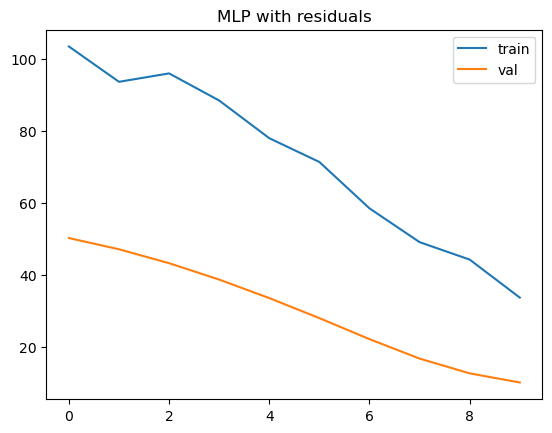

In [17]:
x = [i for i in range(epochs)]
plt.plot(x,loss_train, label='train')
plt.plot(x,loss_val, label='val')
plt.title('MLP with residuals')
plt.legend()
plt.savefig(fname="results/mlp.png")
np.save('results/mlp.npy',loss_train)  
print('MSE loss for val set：',loss_val[-1])
plt.show()

In [129]:
coeff_pred_scaled = model(data)
coeff_pred = norm_inverse(coeff_pred_scaled,scaler)
np.savetxt('./results/prediction_res.csv', coeff_pred.detach().numpy(), delimiter=',')